In [ ]:
import torch as torch
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
import cv2 as cv
from PIL import Image
import numpy as np
from torchvision.datasets.vision import VisionDataset
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import os.path
from torch import nn
from torchvision.datasets.mnist import read_image_file, read_label_file
from torchvision.datasets.utils import download_and_extract_archive, extract_archive, verify_str_arg, check_integrity

In [ ]:
class MNISTsuperimposed(VisionDataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    mirrors = [
        'http://yann.lecun.com/exdb/mnist/',
        'https://ossci-datasets.s3.amazonaws.com/mnist/',
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
        ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
        ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
    ]

    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    def __init__(
            self,
            root,
            train= True,
            transform = None,
            target_transform = None,
            download = False,
    ):
        super(MNISTsuperimposed, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        self.train = train  # training set or test set

        if self._check_legacy_exist():
            self.data, self.targets = self._load_legacy_data()

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        self.data, self.targets = self._load_data()

    def _check_legacy_exist(self):
        processed_folder_exists = os.path.exists(self.processed_folder)
        if not processed_folder_exists:
            return False

        return all(
            check_integrity(os.path.join(self.processed_folder, file)) for file in (self.training_file, self.test_file)
        )

    def _load_legacy_data(self):
        # This is for BC only. We no longer cache the data in a custom binary, but simply read from the raw data
        # directly.
        data_file = self.training_file if self.train else self.test_file
        return torch.load(os.path.join(self.processed_folder, data_file))

    def _load_data(self):
        image_file = f"{'train' if self.train else 't10k'}-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))
        #Technically, we do not even need the labels for now
        # We just need the clean images of both types
        randata = data[torch.randperm(data.shape[0]),:,:]
        targets = (data, randata)
        
        
        # Now do the ambiguation here
        data = data + randata
        return data, targets

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], (self.targets[0][index], self.targets[1][index])
        # doing this so that it is consistent with all other datasets
        # to return a PIL Imagedata[torch.randperm(data.shape[0]),:,:]
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            

        return img, target

    def __len__(self):
        return len(self.data)

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return all(
            check_integrity(os.path.join(self.raw_folder, os.path.splitext(os.path.basename(url))[0]))
            for url, _ in self.resources
        )

    def download(self):
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists():
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = "{}{}".format(mirror, filename)
                try:
                    print("Downloading {}".format(url))
                    download_and_extract_archive(
                        url, download_root=self.raw_folder,
                        filename=filename,
                        md5=md5
                    )
                except URLError as error:
                    print(
                        "Failed to download (trying next):\n{}".format(error)
                    )
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError("Error downloading {}".format(filename))

    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

In [ ]:
class Downsample(object):
    def __init__(self, size=[1,196]):
        self.size=size

    def __call__(self, tensor):
        img = np.squeeze(tensor)
        m = torch.nn.AvgPool2d(2, stride=2)
        return m(img.unsqueeze(0))

    def __repr__(self):
        return self.__class__.__name__+'({})'.format(self.size)

In [ ]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample()
     ])
mnist_superimposed = MNISTsuperimposed("./MNIST data/train", train = True, download = True, transform = transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from torch.utils.data import DataLoader
trainset = DataLoader(mnist_superimposed, batch_size=32, shuffle = False)

In [ ]:
def show_images(dataset, training = True):
    
    fig = plt.figure(figsize = (20, 14))
    rows = 3
    columns = 4
    j=0
    for i in range(1,columns*rows+1):
        if i >=1 and i< 5:
            fig.add_subplot(rows, columns, i)

            plt.imshow(dataset[i][0].squeeze(0))
        if i >=5 and i < 9:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-4][1][0])
        if i >= 9 and i<13:
            fig.add_subplot(rows, columns, i)
            plt.imshow(dataset[i-8][1][1])

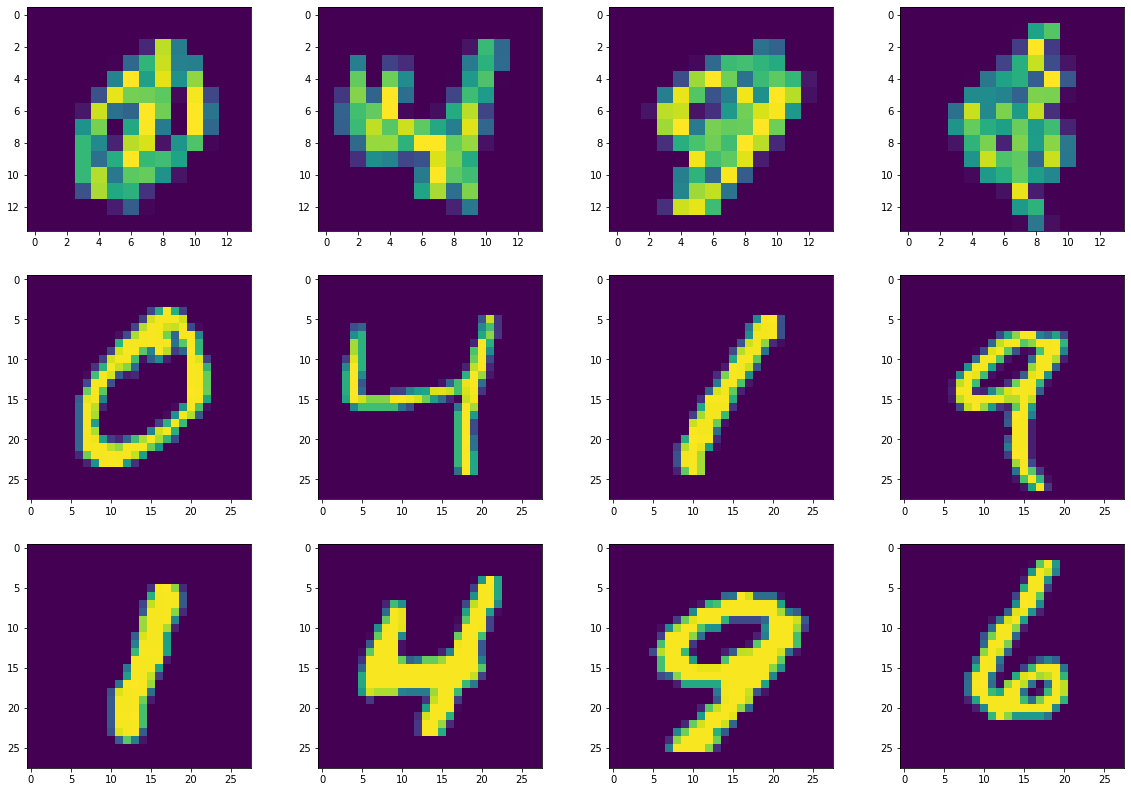

In [ ]:
show_images(mnist_superimposed)

In [ ]:
import torch
from torch import nn as nn
from torch.nn import Conv2d, ConvTranspose2d, Linear, Sequential, Flatten, ReLU, AvgPool2d, MaxPool2d, LeakyReLU

In [ ]:
from pdb import set_trace
class AE(nn.Module):
    def __init__(self):
        super(AE,self).__init__()

        self.Linear_1 = nn.Sequential(
            nn.Flatten(start_dim= 2),
            nn.Linear(196, 256),
            nn.Linear(256, 512),
            nn.Linear(512, 1024),
            nn.LeakyReLU(),

            nn.Linear(1024, 512),
            nn.Linear(512, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 256),
            nn.Linear(256, 392),
            nn.Linear(392, 392),
            nn.ReLU(),
        )
        
        self.Linear_1_5 = nn.Sequential(
            nn.Linear(196, 256),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 512),
            nn.Linear(512, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 196),
            nn.ReLU(),
        )

        self.Encoder_1 = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size = 3, padding = 1, stride = 1),
            nn.Conv2d(1, 4, kernel_size = 5, padding = 1, stride = 1),
            nn.LeakyReLU(),
            nn.Conv2d(4, 16, kernel_size = 5, padding = 1, stride = 1),
            nn.Conv2d(16, 16, kernel_size = 3, padding =1, stride = 1),
            nn.LeakyReLU(),

            nn.Conv2d(16, 8, kernel_size = 3, padding = 1, stride = 1),
            nn.Conv2d(8, 4, kernel_size = 3, padding =1, stride = 1),
            nn.Conv2d(4, 2, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU(),
        )

        self.Encoder_2 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = 5, padding = 2, stride = 1),
            nn.Conv2d(4, 16, kernel_size = 5, padding = 2, stride = 1),
            nn.LeakyReLU(),

            nn.Conv2d(16, 32, kernel_size = 5, padding = 1, stride = 1),
            nn.Conv2d(32, 32, kernel_size = 3, padding = 1, stride = 1),
            nn.LeakyReLU(),

            nn.Conv2d(32, 64, kernel_size = 7, padding = 1, stride = 1),
            nn.Conv2d(64, 64, kernel_size = 3, padding = 1, stride = 1),
            nn.LeakyReLU(),

            nn.Conv2d(64, 16, kernel_size = 3, padding = 1, stride = 1),
            nn.Conv2d(16, 8, kernel_size = 3, padding = 1, stride = 1),
            nn.Conv2d(8, 1, kernel_size = 3, padding = 1, stride = 1),
            nn.ReLU()

        )

        
        self.Linear_2 = nn.Sequential(
            nn.Linear(32, 64),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 392),
            nn.ReLU(),

        )

        self.Decoder_1 = nn.Sequential(
            nn.ConvTranspose2d(2, 16, kernel_size = 5, padding = 1, stride = 1),
            nn.ConvTranspose2d(16, 64, kernel_size = 3, padding= 1, stride = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 128, kernel_size = 5, padding = 1, stride = 1),
            nn.ConvTranspose2d(128, 128, kernel_size = 9, padding = 4, stride = 1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size = 7, padding = 1, stride = 1),
            nn.ConvTranspose2d(64, 64, kernel_size = 7, padding = 3, stride = 1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size= 9, padding = 3, stride = 1),
            nn.ConvTranspose2d(32, 8, kernel_size = 7, padding = 2, stride = 1),
            nn.ConvTranspose2d(8, 2, kernel_size = 5, padding = 1, stride = 1),
            nn.ReLU(),
        )

        self.Decoder_2 = nn.Sequential(
            nn.ConvTranspose2d(2, 32, kernel_size = 9, padding = 4, stride = 1),
            nn.ConvTranspose2d(32, 128, kernel_size = 3, padding = 1, stride = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 1024, kernel_size = 7, padding= 3, stride = 1),
            nn.ConvTranspose2d(1024, 1024, kernel_size = 5, padding = 2, stride = 1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(1024, 256, kernel_size= 3, padding = 1, stride = 1),
            nn.ConvTranspose2d(256, 128, kernel_size= 9, padding =4, stride = 1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 32, kernel_size = 5, padding = 2, stride = 1),
            nn.ConvTranspose2d(32, 32, kernel_size= 3, padding = 1, stride = 1),
            nn.LeakyReLU(),
            
            nn.ConvTranspose2d(32, 8, kernel_size= 3, padding = 1, stride = 1),
            nn.ConvTranspose2d(8, 1, kernel_size= 9, padding = 4, stride = 1),
            nn.ReLU(),
        )

        self.Linear_3 = nn.Sequential(
            nn.Linear(784, 1024),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.Linear(256, 256),
            nn.LeakyReLU(),

            nn.Linear(256, 512),
            nn.Linear(512, 512),
            nn.LeakyReLU(),

            nn.Linear(512, 1024),
            nn.Linear(1024, 1568),
            nn.ReLU(),
        )

        

        
        
        
    def forward(self,x):

      #Step 1
      output = self.Linear_1[:6](x)
      output = self.Linear_1[7](output + self.Linear_1[6](output))
      output = self.Linear_1[8:10](output)
      output = self.Linear_1[11:](output + self.Linear_1[10](output))

      #Step 1.5
      output = output.reshape(32, 2, 14, 14)

        #Image 1
      output_1 = torch.flatten(output[:, :1, :, :], 2)
      output_1 = self.Linear_1_5[:4](output_1)
      output_1 = self.Linear_1_5[5](output_1 + self.Linear_1_5[4](output_1))
      output_1 = self.Linear_1_5[6](output_1)
      output_1 = self.Linear_1_5[8:](output_1 + self.Linear_1_5[7](output_1))

        #Image 2
      output_2 = torch.flatten(output[:, 1:, :, :], 2)
      output_2 = self.Linear_1_5[:4](output_2)
      output_2 = self.Linear_1_5[5](output_2 + self.Linear_1_5[4](output_2))
      output_2 = self.Linear_1_5[6](output_2)
      output_2 = self.Linear_1_5[8:](output_2 + self.Linear_1_5[7](output_2))

      #Step 2

      output_1 = output_1.reshape(32, 1, 14, 14)
      output_2 = output_2.reshape(32, 1, 14, 14)

      output = torch.cat((output_1, output_2), 1)
      
      output = self.Encoder_1[:4](output)
      output = self.Encoder_1[5:](output + self.Encoder_1[4](output))

      #Step 2.5
      output_1 = output[:, :1, :, :]
      output_2 = output[:, 1:, :, :]


        #Image 1
      output_1 = self.Encoder_2[:4](output_1)
      output_1 = self.Encoder_2[5](output_1 + self.Encoder_2[4](output_1))
      output_1 = self.Encoder_2[6](output_1)
      output_1 = self.Encoder_2[8:](output_1 + self.Encoder_2[7](output_1))

        #Image 2
      output_2 = self.Encoder_2[:4](output_2)
      output_2 = self.Encoder_2[5](output_2 + self.Encoder_2[4](output_2))
      output_2 = self.Encoder_2[6](output_2)
      output_2 = self.Encoder_2[8:](output_2 + self.Encoder_2[7](output_2))  

      #Step 3
      output = torch.cat((output_1, output_2), 1)
      output = torch.flatten(output, start_dim=1).reshape(32, 1, 32)

      output = self.Linear_2[:4](output)
      output = self.Linear_2[5:](output + self.Linear_2[4](output))
      
      #Step 4
      output = output.reshape(32, 2, 14, 14)

      output = self.Decoder_1[:4](output)
      output = self.Decoder_1[5](output + self.Decoder_1[4](output))
      output = self.Decoder_1[6](output)
      output = self.Decoder_1[8:](output + self.Decoder_1[7](output))

      #Step 4.5
      
      output = self.Decoder_2[:4](output)
      output = self.Decoder_2[5](output + self.Decoder_2[4](output))
      output = self.Decoder_2[6:10](output)
      output = self.Decoder_2[11:](output + self.Decoder_2[10](output))

      output = torch.flatten(output, 2)

      #Step 5
      output = self.Linear_3[:4](output)
      output = self.Linear_3[5](output + self.Linear_3[4](output))
      output = self.Linear_3[6](output)
      output = self.Linear_3[8:](output + self.Linear_3[7](output))

      output = output.reshape(32, 2, 28, 28)

      # print(output.shape)

                        
      return output
        
        

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
AEnet = AE().to(device)
optimizer = torch.optim.Adam(AEnet.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
print(device)

cuda


In [ ]:
fig = plt.figure(figsize = (10, 7))
rows = 1
columns = 5

epochs = 10
train_loss = []
flag = True
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainset):
        optimizer.zero_grad()
        outputs = AEnet(data[0].float().to(device))
#         print(outputs.shape)
        loss = criterion(outputs.reshape(-1).to(device),torch.stack((data[1][0].float().to(device), data[1][1].float().to(device)), axis=1).reshape(-1))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss per image: %.6f' %
                  (epoch + 1, i + 1, loss.item()/32))
#             print(outputs.shape)
#             img_1 = outputs[0, 0, :]
#             img_2 = outputs[0, 1, :]
#             true_1 = torch.flatten(data[1][1][0])
#             true_2 = torch.flatten(data[1][0][0])
#             loss_1 = criterion(img_1.to(device), true_1.to(device))
#             loss_2 = criterion(img_2.to(device), true_2.to(device))
#             print(loss_1, loss_2)
#             print(img_1.shape, img_2.shape, true_1.shape, true_2.shape)
            
#             true_1 = data[1][0][0]
#             true_2 = data[1][0][1]
#             output_1 = outputs[0].reshape((2, 28, 28))
#             predic_1 = torch.Tensor.cpu(output_1[0])
#             predic_2 = torch.Tensor.cpu(output_1[1])
#             print(output_1.shape)
#             print(predic_1.shape, predic_2.shape, true_1.shape, true_2.shape)
            
#             print(data[0][0][0].shape)
#             given = data[0][0][0]
            
#             fig.add_subplot(rows, columns, 1)
#             plt.imshow(true_1, cmap = 'gray')
#             plt.axis("off")
#             plt.title("First True")
            
#             fig.add_subplot(rows, columns, 2)
#             plt.imshow(true_2, cmap = 'gray')
#             plt.axis("off")
#             plt.title("Second True")
            
#             fig.add_subplot(rows, columns, 3)
#             plt.imshow(given)
#             plt.axis("off")
#             plt.title("Given")
            
#             fig.add_subplot(rows, columns, 4)
#             plt.imshow(predic_1.detach().numpy())
#             plt.axis("off")
#             plt.title("First Prediction")
            
#             fig.add_subplot(rows, columns, 5)
#             plt.imshow(predic_2.detach().numpy())
#             plt.axis("off")
#             plt.title("Second Predicition")

#         def closure():
#             if torch.is_grad_enabled():
#                 optimizer.zero_grad()
#             outputs=AEnet(data[0].float().to(device))
#             loss = criterion(outputs.reshape(-1).to(device),torch.stack((data[1][0].float().to(device), data[1][1].float().to(device)), axis=0).reshape(-1))
#             if loss.requires_grad:
#                 loss.backward()
#             return loss
            
print("The lowest was: ", min(train_loss)/32)
        
print('Finished Training')
flag = False

[1,   100] loss per image: -144420424044200534736896.000000
[1,   200] loss per image: -560256728786550405464064.000000
[1,   300] loss per image: -811282832387757463044096.000000


KeyboardInterrupt: ignored

<Figure size 720x504 with 0 Axes>

torch.Size([2, 28, 28])


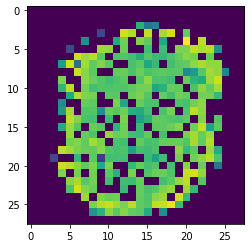

In [ ]:
print(outputs[0].shape)
plt.imshow(outputs[0][1,:,:].reshape(28,28).cpu().detach().numpy())

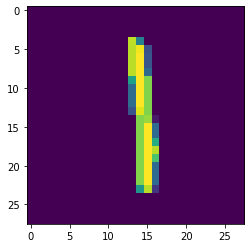

In [ ]:
plt.imshow(data[1][1][1].squeeze(0))


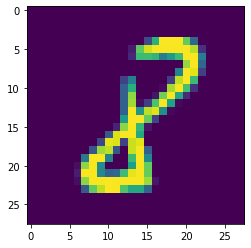

In [ ]:
plt.imshow(data[1][0][1].squeeze(0))